In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np


from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


from model import ModelArgs, TransformerForSequenceClassification


import os

device = "cuda" if torch.cuda.is_available() else 'cpu'

In [2]:
df = pd.read_csv("../../data/data_with_scaled_grades.csv")
df = df[["essay", "scaled_grade"]]
def let_to_num(row):
    k = {"F": 0, "D": 1, "C": 2, "B": 3, "A": 4}
    return k[row]


df["num_grade"] = df["scaled_grade"].apply(let_to_num)


dfl1 = pd.read_csv('../../data/lexical_features_5_07.csv')
dfl1 = dfl1[['essay_id','num_chars_essay', 'num_puncts_essay', 'num_words_essay',
       'num_unique_words_essay', 'num_correct_words', 'num_noun', 'num_adj']]

dfl2 = pd.read_csv('../../data/lexical_avg_features_5_12.csv')
dfl2 = dfl2[['essay_id','avg_num_chars_word',
       'avg_num_chars_sent', 'avg_num_puncts_word', 'avg_num_puncts_sent',
       'avg_num_words_sent', 'avg_num_unique_words_essay']]

dfl = dfl1.join(dfl2,lsuffix='l').drop(columns=['essay_idl'])


dfl = (dfl - dfl.mean()) / dfl.std() # normalize

df = pd.concat([df,dfl],axis=1)

tr = round(len(df) * 0.8)
val = round(len(df) * 0.1)

df_train = df[0:tr]
df_val = df[tr : tr + val]
df_test = df[tr + val :]

In [3]:
def chunk_and_embed(text,tokenizer,model, chunk_size=512):
    tokens = tokenizer.tokenize(text)
    max_chunk_size = chunk_size - 2 
    chunked_tokens = [tokens[i:i + max_chunk_size] for i in range(0, len(tokens), max_chunk_size)]

 
    chunked_input_ids = [tokenizer.convert_tokens_to_ids(['[CLS]'] + chunk + ['[SEP]']) for chunk in chunked_tokens]

    ins = [torch.tensor(x) for x in chunked_input_ids]

    with torch.no_grad():
        out = [model(input_ids = ins[x].unsqueeze(0)).last_hidden_state for x in range(len(ins))]


    return torch.cat(out,dim=1).squeeze(0)


In [4]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
embeddings_model = BertModel.from_pretrained('bert-base-uncased')

In [5]:
class EssayDataset(Dataset):
    def __init__(self, essay_df, tokenizer,model):

        self.row_dicts = []

        for i,row in essay_df.iterrows():      
            self.row_dicts.append(row.to_dict())


        self.model = model
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.row_dicts)

    def __getitem__(self, index):

        row = self.row_dicts[index]

        essay = row['essay']

        embeddings = chunk_and_embed(essay,self.tokenizer,self.model)
        score = row['num_grade']
        num_chars = row['num_chars_essay']
        num_puncts = row['num_puncts_essay']
        num_words = row['num_words_essay']
        num_unique_w = row['num_unique_words_essay']
        num_correct = row['num_correct_words']
        num_noun = row['num_noun']
        num_adj = row['num_adj']


        context = torch.tensor([num_chars,num_puncts,num_words,num_unique_w,num_correct,num_noun,num_adj],dtype=torch.float)


    

        return {
            'embedding':embeddings,
            'context':context,
            'label': torch.tensor([score],dtype=torch.long).squeeze(0)
            
        }

    def num_classes(self):
        return 5 # bad

    def __repr__(self) -> str:
        return f"Dataset with {len(self)} essays"


ds_train = EssayDataset(df_train, tokenizer,embeddings_model)
ds_val = EssayDataset(df_val, tokenizer,embeddings_model)

In [6]:
ds_train[0]['embedding'].shape

torch.Size([425, 768])

In [7]:
config = ModelArgs(
    dim=768,
    n_layers=42,
    n_heads=48,
    n_classes=ds_train.num_classes(),
)

model = TransformerForSequenceClassification(config)
print(f"{model.params():,}")

state_dict = torch.load('weights/model_epoch_9.pt')
model.load_state_dict(state_dict)
del state_dict

model = model.to(device)


297,346,565


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=2)

from torch.nn.utils.rnn import pad_sequence
import torch


def collate_batch(batch):
    data, labels = zip(*batch)

    padded_data = pad_sequence(
        data, batch_first=True, padding_value=0
    )  

    labels = torch.tensor(labels)

    return padded_data, labels

train_dataloader = DataLoader(ds_train, batch_size=1, shuffle=True)
val_dataloader = DataLoader(ds_val, batch_size=1, shuffle=True)


In [9]:
start_epoch = 7
end_epoch = 10
batch_losses = []
val_losses = []
val_accuracies = []
for epoch in range(start_epoch,end_epoch):
    torch.cuda.empty_cache()
    model.train()
    batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
    running_loss = 0.0
    for batch_idx,batch in enumerate(batch_iterator):

        embeddings = batch['embedding'].to(device)
        context = batch['context'].to(device)
        labels = batch['label'].to(device)

        out = model(embeddings,context)
        loss = loss_fn(out, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_losses.append(running_loss /( 1 if batch_idx == 0 else batch_idx))

        running_loss += loss.item()

        batch_iterator.set_postfix(loss=running_loss /( 1 if batch_idx == 0 else batch_idx))
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        val_iterator = tqdm(val_dataloader,desc=f"Validating Epoch {epoch:02d}")
        for idx,batch in enumerate(val_iterator):

            embeddings = batch['embedding'].to(device)
            context = batch['context'].to(device)
            labels = batch['label'].to(device)
            
            out = model(embeddings,context)
            loss = loss_fn(out,labels)

            val_loss += loss.item()

            preds = torch.argmax(out, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            preds = torch.argmax(out, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_losses.append(loss.item())
            val_accuracies.append(val_correct / val_total)

    scheduler.step(val_loss)


    val_loss /= len(val_dataloader)
    val_accuracy = val_correct / val_total

    torch.save(model.state_dict(), os.path.join('weights', f'model_epoch_{epoch+1}.pt'))

    print(
        f"Epoch [{epoch+1}/{end_epoch}], Train Loss: {running_loss / len(train_dataloader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
    )


Validating Epoch 07: 100%|██████████| 1298/1298 [01:34<00:00, 13.71it/s]


Epoch [8/10], Train Loss: 0.7170, Val Loss: 1.6200, Val Accuracy: 0.4422


Validating Epoch 08: 100%|██████████| 1298/1298 [01:34<00:00, 13.69it/s]


Epoch [9/10], Train Loss: 0.7148, Val Loss: 1.4506, Val Accuracy: 0.4561


Processing Epoch 09:   0%|          | 1/10382 [00:00<1:30:20,  1.92it/s, loss=0.659]


KeyboardInterrupt: 

In [24]:
ds_test = EssayDataset(df_test[500:1000], tokenizer,embeddings_model)
test_dataloader = DataLoader(ds_test, batch_size=1, shuffle=True)


In [25]:
preds = []
labels = []
for i in tqdm(range(len(test_dataloader))):
    embeddings = ds_test[i]['embedding'].unsqueeze(0).to(device)
    context = ds_test[i]['context'].unsqueeze(0).to(device)
    label = ds_test[i]['label'].unsqueeze(0).to(device)

    
    out = model(embeddings,context)
    pred = torch.argmax(out)
    out = out.to('cpu')
    del out

    preds.append(pred)
    labels.append(label)


100%|██████████| 500/500 [04:28<00:00,  1.86it/s]


In [34]:
preds = torch.stack(preds).cpu().numpy()
labels = torch.stack(labels).squeeze().cpu().numpy()



TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not numpy.ndarray

In [39]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(labels,preds)

In [40]:
conf_matrix

array([[  1,   7,   3,   1,   1],
       [  2,  16,  21,  65,  70],
       [  0,  11,  12,  15,  63],
       [  0,   7,  10,  11, 165],
       [  0,   0,   3,   6,  10]])

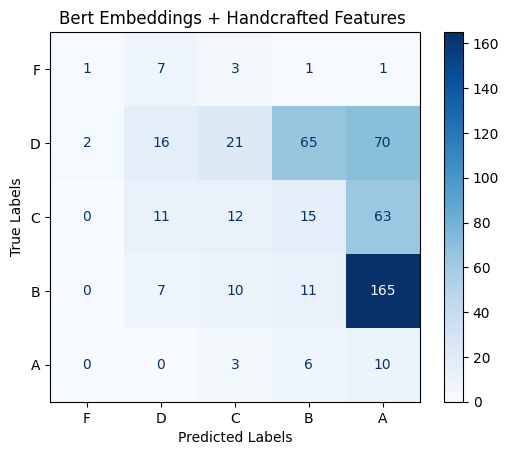

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["F", "D", "C", "B", "A"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)  

ax.set_title('Bert Embeddings + Handcrafted Features ')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

plt.show()

In [42]:
def quadratic_weighted_kappa(conf_matrix):

    w = np.zeros_like(conf_matrix, dtype=float)

    num_categories = conf_matrix.shape[0] 

    for i in range(num_categories):
        for j in range(num_categories):
            w[i, j] = ((i - j) / (num_categories - 1)) ** 2


    total_observations = conf_matrix.sum()

    row_totals = conf_matrix.sum(axis=1)

    col_totals = conf_matrix.sum(axis=0)

    e = np.zeros_like(conf_matrix, dtype=float)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            e[i, j] = (row_totals[i] * col_totals[j]) / total_observations


    num = 0
    den = 0
    for i in range(num_categories):
        for j in range(num_categories):
            num += (w[i,j] * conf_matrix[i,j])
            den += (w[i,j] * e[i,j])

    return 1 - (num/den)

In [43]:
quadratic_weighted_kappa(conf_matrix)

0.19068127294274084

In [18]:
from sklearn.metrics import classification_report
report = classification_report(labels, preds, target_names=["f","d","c",'b','a'])


In [19]:
print(report)

              precision    recall  f1-score   support

           f       0.78      0.19      0.31        36
           d       0.37      0.70      0.49       123
           c       0.45      0.53      0.49       206
           b       0.21      0.14      0.17       111
           a       0.78      0.14      0.23       103

    accuracy                           0.40       579
   macro avg       0.52      0.34      0.34       579
weighted avg       0.47      0.40      0.37       579

